# A Tutorial on Dataset Cleaning with Cleanlab and CLIP

#### Author: Antonio Rueda-Toicen
#### [AI Services @ Hasso Plattner Institute](https://hpi.de/kisz/home.html)
**antonio.rueda.toicen 'at' hpi 'dot' de**


[![Creative Commons License](https://i.creativecommons.org/l/by/4.0/88x31.png)](http://creativecommons.org/licenses/by/4.0/)

This work is licensed under a [Creative Commons Attribution 4.0 International License](http://creativecommons.org/licenses/by/4.0/).



### Cleanlab Overview

`cleanlab` is a Python library designed for machine learning on noisy data. It allows us to identify label errors in datasets.

One of the core methodologies `cleanlab` uses is based on the concept of [confident learning](https://arxiv.org/pdf/1911.00068.pdf). Confident learning characterizes label errors in datasets throught the level of confidence (the probability) that a model has on labels that it has assigned on its test set.

![](https://github.com/andandandand/images-for-colab-notebooks/blob/main/Screenshot%202024-03-04%20at%2012.00.26.png?raw=true)



### Estimating Label Noise with Cleanlab

To estimate label noise using `cleanlab`, we typically follow these steps:

1. **Train a Preliminary Model**: Train a model on your dataset as you normally would. This model doesn't have to be perfect; its purpose is to generate predictions that `cleanlab` can use to identify potential label errors.

2. **Compute the Prediction Probabilities**: Use the trained model to compute the prediction probabilities for each sample in the dataset. These probabilities are used by cleanlab to assess the confidence in each prediction.

3. **Use Cleanlab to Identify Noisy Labels**: `cleanlab` works by comparing the model's prediction probabilities with the actual labels. For each sample, it looks for cases where the model is highly confident in its prediction (high probability for $\hat{y}$), but the prediction does not match the given label ($y^*$). These cases are flagged as potential label errors.

4. **Rank and Review Noisy Labels**: `cleanlab` provides ranked lists of potential label errors. These rankings are based on the discrepancy between the model's confidence and the actual label, allowing us to prioritize which labels to review manually.


## Finding potential labelling issues with cleanlab's Datalab

We can use Cleanlab's Datalab to do 'confident learning' and identify labeling issues and outliers in our image dataset. For this we need:

1. The output probabilities for an image classifier, these should come from a 'test set', meaning that if we use our own model we need to do hierarchical cross-validation on the dataset
2. The image embeddings
3. A [Hugginface dataset](https://pypi.org/project/datasets/) with the (preliminary) ground truth and the image paths

```python
from cleanlab import Datalab

# Pass a Hugginface Dataset with ground_truth labels in a column named 'labels'
# and the paths to images in a column called 'image'.
lab = Datalab(data=your_dataset, label_name="labels", imagekey='image')
# Specify the predicted probabilities for classes and
# the vector embeddings for each image.
lab.find_issues(pred_probs=pred_probs, features=image_embeddings)
# Report the labeling issues (using the probabilities) and the outliers (using the embeddings)
lab.report()
```

In this notebook, we use a pretrained CLIP model to produce both the output probabilities and the image embeddings for our dirty 'lion/boar' dataset. Please refer to our previous tutorials to understand the behavior of CLIP as a zero-shot classifier and embedding model.   


In [1]:
!pip install transformers==4.38.1 -q

In [2]:
!pip install 'cleanlab[datalab]'==2.6.0 -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.3/325.3 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.8 MB/s eta 0:00:00


In [3]:
from datasets import Dataset, Features, Image, Value
from PIL import Image as PILImage



In [4]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [5]:
from pathlib import Path
import os
path = Path("/gdrive/MyDrive/image_dataset_curation_workshop_4/raw_data")
os.listdir(path)

['female_lion',
 'male_lion',
 'boar',
 'lion_cub',
 'lion_hunt_eugene_delacroix',
 'lion_resting_turned_to_the_left_rembrandt',
 'sleeping_gipsy_henri_rousseau',
 'lion_rosa_bonheur',
 'laptop_computer']

In [6]:
from transformers import CLIPProcessor, CLIPModel
import torch
from PIL import Image as PILImage
import requests

In [7]:
model = CLIPModel.from_pretrained('openai/clip-vit-base-patch32')
model

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e-05,

In [8]:
processor = CLIPProcessor.from_pretrained('openai/clip-vit-base-patch32')
processor

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

CLIPProcessor:
- image_processor: CLIPImageProcessor {
  "crop_size": {
    "height": 224,
    "width": 224
  },
  "do_center_crop": true,
  "do_convert_rgb": true,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.48145466,
    0.4578275,
    0.40821073
  ],
  "image_processor_type": "CLIPImageProcessor",
  "image_std": [
    0.26862954,
    0.26130258,
    0.27577711
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "shortest_edge": 224
  }
}

- tokenizer: CLIPTokenizerFast(name_or_path='openai/clip-vit-base-patch32', vocab_size=49408, model_max_length=77, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|startoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>', 'pad_token': '<|endoftext|>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	49406: AddedToken("<|startoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True, spe

In [9]:
descriptions = ['lion', 'boar', 'female_lion', 'male_lion',
                'lion_cub',
                'human', # collecting data-garbage labels
                'toy',
                'text',
                'computer']

text_inputs = processor(descriptions, return_tensors='pt',
                        padding=True, truncation=True)



Here's a breakdown of what each part of the code does:

1. **`descriptions = ['lion', 'boar']`**: This line creates a list of textual descriptions that you want to process. In this case, you're looking at two descriptions: 'lion' and 'boar'.

2. **`text_inputs = processor(descriptions, return_tensors='pt', padding=True, truncation=True)`**:
   - `processor`: This is an instance of `CLIPProcessor`, which is responsible for preprocessing the text and (optionally) images in a way that's suitable for the CLIP model. It combines a text tokenizer and an image processor under the hood.
   - `descriptions`: The list of textual descriptions you want to preprocess.
   - `return_tensors='pt'`: This argument specifies the format of the returned tensors; `'pt'` indicates that you want the tensors to be PyTorch tensors. If you were using TensorFlow, you would use `'tf'` instead.
   - `padding=True`: This enables padding. Since you can process multiple texts at once, and they can be of different lengths, padding ensures that all processed text tensors have the same length by adding padding tokens where necessary.
   - `truncation=True`: This enables truncation. If any text description is longer than the model's maximum input length, it will be truncated to fit.

The result, `text_inputs`, is a dictionary containing the processed tensor(s) along with any other relevant information needed by the CLIP model to understand the text inputs. This dictionary can directly be passed to the CLIP model for inference tasks such as generating embeddings for the descriptions, which can then be used for comparison against image embeddings, among other tasks.

In [10]:
with torch.no_grad():
  text_embeddings = model.get_text_features(**text_inputs)

In [11]:
text_embeddings.shape

torch.Size([9, 512])

In [12]:
cosine_similarity = torch.nn.CosineSimilarity(dim=0, eps=1e-6)

In [13]:
cosine_similarity(text_embeddings[0], text_embeddings[1])

tensor(0.8524)

In [14]:
import skimage.io as io

In [15]:
import random
random.seed(42)
# For the sake of time, we start cleaning only the female_lion and boar folders
# Feel free to include the other subfolders in raw_data as an asssingment
female_lion_filenames = random.sample([path / 'female_lion' / filename for filename in os.listdir(path / 'female_lion') if '.jpg' in filename], 50)

boar_filenames = random.sample([path / 'boar' / filename for filename in os.listdir(path / 'boar') if '.jpg' in filename], 50)

filenames = female_lion_filenames + boar_filenames

images = [PILImage.open(filename).convert('RGB').resize((512, 512)) for filename in filenames]

In [16]:
inputs = processor(images=images,
                   return_tensors="pt")
inputs.keys()

dict_keys(['pixel_values'])

In [17]:
image_embeddings = model.get_image_features(**inputs).detach()
image_embeddings

tensor([[ 0.0112, -0.1468, -0.3491,  ...,  0.5061,  0.1661,  0.1239],
        [-0.3858, -0.0360,  0.0653,  ...,  0.2956, -0.3785,  0.0921],
        [-0.1586, -0.1831, -0.0637,  ...,  0.3038,  0.1168, -0.1511],
        ...,
        [-0.0546, -0.1765, -0.1638,  ...,  0.4028,  0.3573, -0.0306],
        [-0.2693, -0.1717,  0.1849,  ...,  1.3345, -0.3732,  0.0053],
        [ 0.1973, -0.4281,  0.0857,  ...,  0.7610,  0.2201, -0.1144]])

In [18]:
image_embeddings.shape

torch.Size([100, 512])

In [19]:
inputs = processor(text=descriptions,
                   images=images,
                   return_tensors="pt", padding=True)
outputs = model(**inputs)
logits_per_image = outputs.logits_per_image
temperature = 1.0
# we use detach() to get rid of the gradient computation graph
probs = (logits_per_image/temperature).softmax(dim=1).detach()



In [20]:
probs.shape

torch.Size([100, 9])

In [21]:
import matplotlib.pyplot as plt
import numpy as np

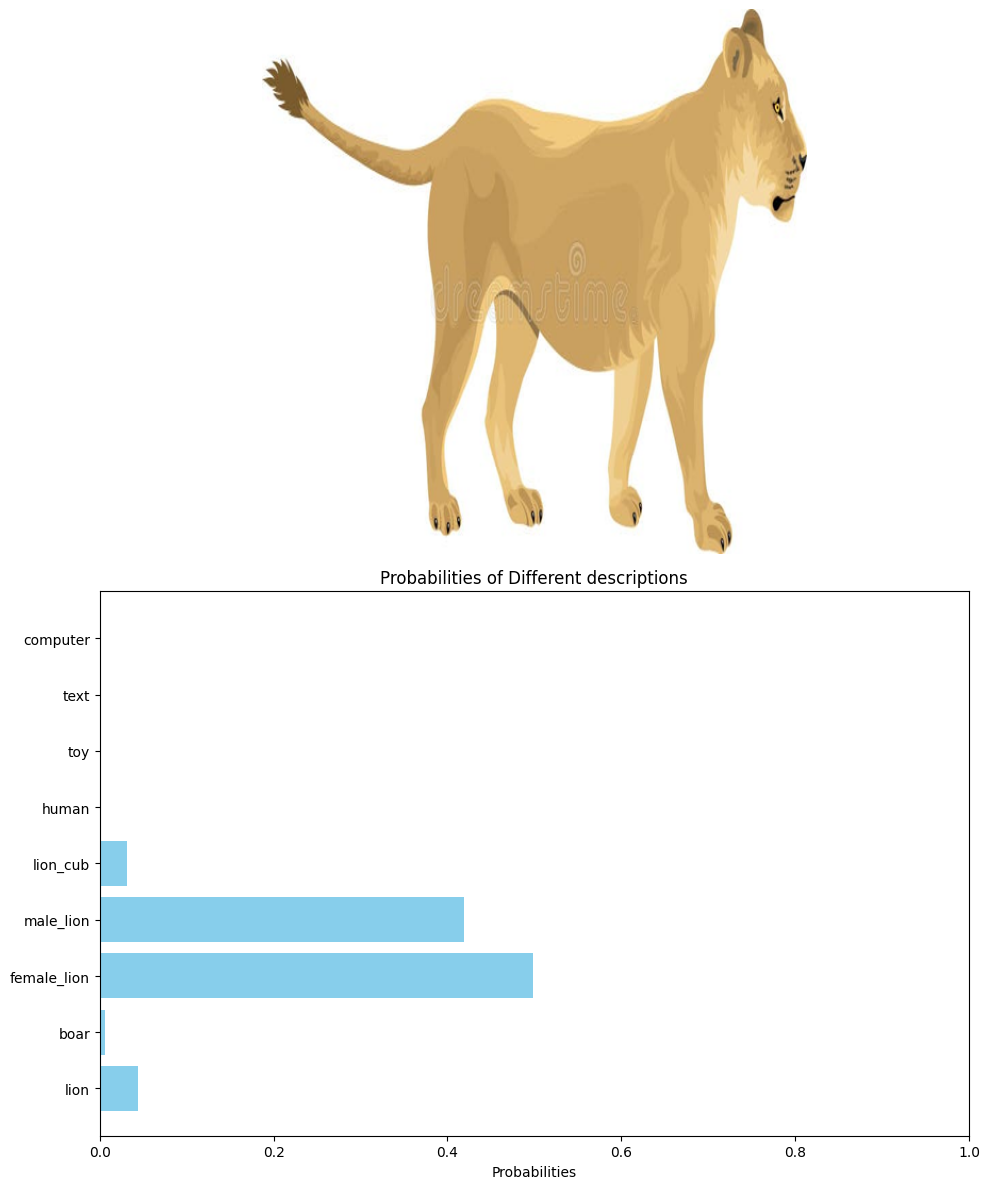

In [22]:
# @title {run:'auto'}

slider_value = 23  # @param {type: "slider", min: 0, max: 99}
temperature = 1.1  # @param {type: "slider", min: 0, max: 2, step:0.1}

# Creating a subplot with an image in the first row and the histogram in the second row
fig, axes = plt.subplots(2, 1, figsize=(10, 12))

axes[0].imshow(np.array(images[slider_value]))
axes[0].axis('off')  # Turning off the axis for the image

# Creating the horizontal bar plot in the second subplot
axes[1].barh(descriptions, probs[slider_value].detach(), color='skyblue')
axes[1].set_xlim(0, 1)  # Setting the x-axis limit from 0 to 1

axes[1].set_xlabel('Probabilities')
axes[1].set_title('Probabilities of Different descriptions')

plt.tight_layout()
plt.show()

In [23]:
probs[0]

tensor([5.3404e-01, 3.0112e-01, 7.2240e-02, 6.6057e-02, 1.5600e-02, 5.9179e-03,
        6.4116e-04, 4.1259e-03, 2.6428e-04])

In [24]:
filenames[0]

PosixPath('/gdrive/MyDrive/image_dataset_curation_workshop_4/raw_data/female_lion/Image_169.jpg')

In [25]:
image_embeddings[0].shape

torch.Size([512])

In [26]:
probs_and_embeddings_dict = {filename:{'probs': probs[index].detach().numpy(),
                                       'embedding':image_embeddings[index]}
                             for index, filename in enumerate(filenames)}

In [27]:
import pickle

# Open a file in binary write mode
with open(path.parent / 'clip_probs_and_embeddings.pkl', 'wb') as file:
    # Use pickle.dump() to serialize and save the dictionary
    pickle.dump(probs_and_embeddings_dict, file)


In [28]:
path.parent

PosixPath('/gdrive/MyDrive/image_dataset_curation_workshop_4')

In [29]:
len(descriptions), probs.detach().numpy().shape

(9, (100, 9))

In [30]:
probs.shape

torch.Size([100, 9])

In [31]:
# Apply argmax on the first dimension
indices = torch.argmax(probs, dim=1)
labels = [descriptions[i] for i in indices]

In [32]:
import pandas as pd
dataset = pd.DataFrame({'image':images, 'label':labels})
dataset.label.value_counts()

boar           38
female_lion    25
male_lion      21
lion            4
lion_cub        4
text            3
toy             3
human           1
computer        1
Name: label, dtype: int64

In [33]:
probs.shape

torch.Size([100, 9])

In [34]:
!pip install cleanvision -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 8.9 MB/s eta 0:00:00


In [35]:
!pip install datasets==2.4.0 -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.8/95.8 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.1/133.1 kB 10.5 MB/s eta 0:00:00


In [36]:
print(dataset['image'][0])

<PIL.Image.Image image mode=RGB size=512x512 at 0x7B777A6E5B10>


In [37]:
from datasets import Dataset, Features, Image, Value
from PIL import Image as PILImage

features = Features({
    'label': Value(dtype='string'),
    'image': Image(),
})

image_feature = Image()
encoded_image = image_feature.encode_example(images[0])


In [38]:
encoded_images = [image_feature.encode_example(pil_image) for pil_image in images]


In [39]:
df = pd.DataFrame({"label": labels, "image": encoded_images})
dataset = Dataset.from_pandas(df, features=features)
df.label.value_counts()
dataset

Dataset({
    features: ['label', 'image'],
    num_rows: 100
})

In [40]:
from cleanlab import Datalab
lab = Datalab(data=dataset, label_name="label", image_key='image')
lab

Datalab(task=Classification, checks_run=False, num_examples=100, num_classes=9, issues_identified=Not checked)

In [41]:
probs.numpy()

array([[5.34037173e-01, 3.01116705e-01, 7.22400248e-02, 6.60573021e-02,
        1.55995684e-02, 5.91788022e-03, 6.41163962e-04, 4.12588101e-03,
        2.64277915e-04],
       [7.84148201e-02, 1.08260964e-03, 4.39673781e-01, 3.04492712e-01,
        1.75016627e-01, 6.18331949e-04, 3.52670584e-04, 3.29568255e-04,
        1.88030954e-05],
       [1.67371124e-01, 1.72064028e-04, 4.67835248e-01, 3.27754885e-01,
        3.63920368e-02, 1.99623275e-04, 4.99361449e-05, 2.21308699e-04,
        3.83430415e-06],
       [9.78355408e-02, 1.11384696e-04, 3.47387463e-01, 4.76025671e-01,
        7.84228742e-02, 7.27297811e-05, 8.37320622e-05, 5.93938385e-05,
        1.29074863e-06],
       [4.75815050e-02, 5.80719498e-04, 3.79706264e-01, 5.30893326e-01,
        4.11136933e-02, 3.51100534e-05, 2.76852697e-05, 5.88262046e-05,
        2.87113971e-06],
       [4.75316010e-02, 1.63475052e-05, 4.56501633e-01, 4.73348498e-01,
        2.25816108e-02, 9.48061188e-06, 3.12790667e-06, 7.21965307e-06,
        4.4

In [42]:
lab.find_issues(features=image_embeddings, pred_probs=probs.numpy())


Finding null issues ...
Error in null: mean(): could not infer output dtype. Input dtype must be either a floating point or complex dtype. Got: Byte
Finding label issues ...


/usr/local/lib/python3.10/dist-packages/cleanlab/filter.py:904: UserWarning: May not flag all label issues in class: 7, it has too few examples (see `min_examples_per_class` argument)
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/cleanlab/filter.py:904: UserWarning: May not flag all label issues in class: 4, it has too few examples (see `min_examples_per_class` argument)
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/cleanlab/filter.py:904: UserWarning: May not flag all label issues in class: 3, it has too few examples (see `min_examples_per_class` argument)
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/cleanlab/filter.py:904: UserWarning: May not flag all label issues in class: 5, it has too few examples (see `min_examples_per_class` argument)
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/cleanlab/filter.py:904: UserWarning: May not flag all label issues in class: 8, it has too few examples (see `min_examples_per_class` argument)
  warnings.w

Finding outlier issues ...
Fitting OOD estimator based on provided features ...
Finding near_duplicate issues ...
Finding non_iid issues ...
Finding class_imbalance issues ...
Finding underperforming_group issues ...
Failed to check for these issue types: [NullIssueManager]
Finding dark, light, low_information, odd_aspect_ratio, odd_size, grayscale, blurry images ...


  0%|          | 0/100 [00:00<?, ?it/s]


Audit complete. 46 issues found in the dataset.


In [43]:
lab.report()

Here is a summary of the different kinds of issues found in the data:

     issue_type  num_issues
          label          39
 near_duplicate           4
        outlier           1
        non_iid           1
class_imbalance           1

Dataset Information: num_examples: 100, num_classes: 9


----------------------- label issues -----------------------

About this issue:
	Examples whose given label is estimated to be potentially incorrect
    (e.g. due to annotation error) are flagged as having label issues.
    

Number of examples with this issue: 39
Overall dataset quality in terms of this issue: 0.2800

Examples representing most severe instances of this issue:
    is_label_issue   label_score given_label predicted_label
91            True  9.232342e-07        boar        computer
5             True  3.127907e-06   male_lion           human
10           False  4.454446e-06   male_lion           human
51            True  4.800293e-06        boar        computer
76            True

Examples representing most severe instances of this issue:

```
    is_near_duplicate_issue  near_duplicate_score near_duplicate_sets  distance_to_nearest_neighbor
70                     True              0.003945                [88]                      0.000463
88                     True              0.003945                [70]                      0.000463
64                     True              0.106043                [54]                      0.013117
54                     True              0.106043                [64]                      0.013117
31                    False              0.262518                  []                      0.035631
```

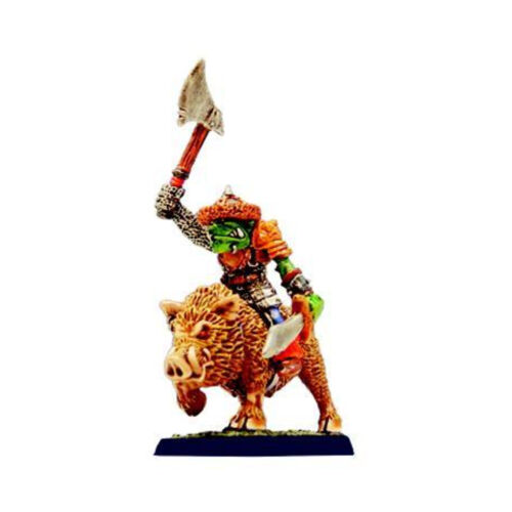

In [44]:
dataset[70]['image']

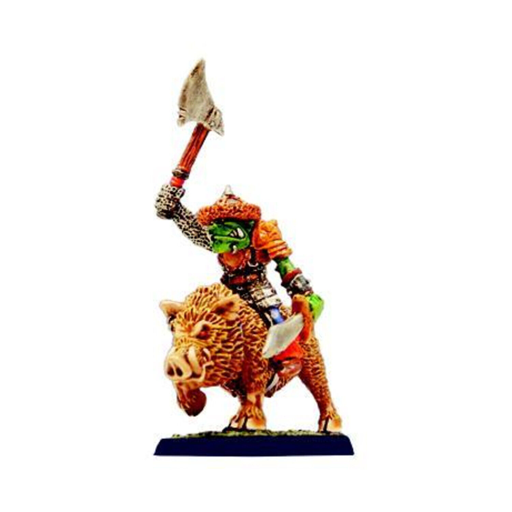

In [45]:
dataset[88]['image']

In [46]:
label_issues = lab.get_issues("label")
label_issues.head()

,is_label_issue,label_score,given_label,predicted_label
0,False,0.015600,lion,boar
1,False,0.439674,female_lion,female_lion
2,False,0.467835,female_lion,female_lion
3,True,0.000084,male_lion,human
4,True,0.000028,male_lion,human


In [47]:
label_issues_df = label_issues.query("is_label_issue").sort_values("label_score")
label_issues_df.head()

,is_label_issue,label_score,given_label,predicted_label
91,True,9.232342e-07,boar,computer
5,True,3.127907e-06,male_lion,human
51,True,4.800293e-06,boar,computer
76,True,5.187903e-06,boar,computer
28,True,5.337468e-06,male_lion,human




```

----------------------- label issues -----------------------

About this issue:
	Examples whose given label is estimated to be potentially incorrect
    (e.g. due to annotation error) are flagged as having label issues.
    

Number of examples with this issue: 68
Overall dataset quality in terms of this issue: 0.0700

Examples representing most severe instances of this issue:
    is_label_issue   label_score given_label predicted_label
91            True  9.232581e-07        boar         cartoon
37            True  2.418162e-06        lion            boar
51            True  4.801754e-06        boar         cartoon
76            True  5.187743e-06        boar         cartoon
10            True  6.189827e-06        lion            boar

```



female_lion


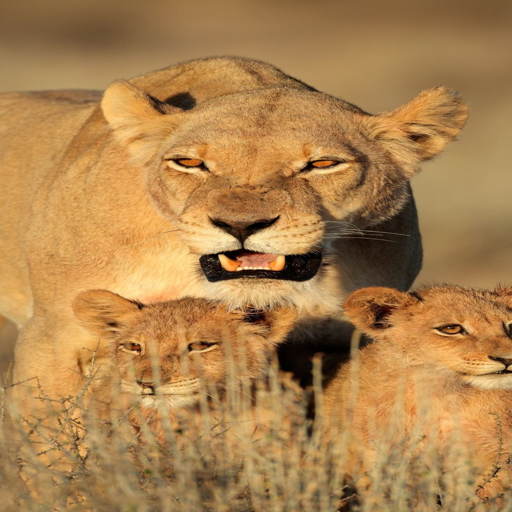

In [48]:
print(dataset[1]['label'])
dataset[1]['image']

In [49]:
import math
# Note: This pulldown content is for docs.cleanlab.ai, if running on local Jupyter or Colab, please ignore it.

def plot_label_issue_examples(label_issues_df, num_examples=15):
    ncols = 5
    nrows = int(math.ceil(num_examples / ncols))

    _, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(1.5 * ncols, 1.5 * nrows))
    axes_list = axes.flatten()
    label_issue_indices = label_issues_df.index.values

    for i, ax in enumerate(axes_list):
        if i >= num_examples:
            ax.axis("off")
            continue
        idx = int(label_issue_indices[i])
        row = label_issues.loc[idx]
        ax.set_title(
            f"id: {idx}\n GL: {row.given_label}\n SL: {row.predicted_label}",
            fontdict={"fontsize": 8},
        )
        ax.imshow(dataset[idx]["image"], cmap="gray")
        ax.axis("off")
    plt.subplots_adjust(hspace=0.7)
    plt.show()

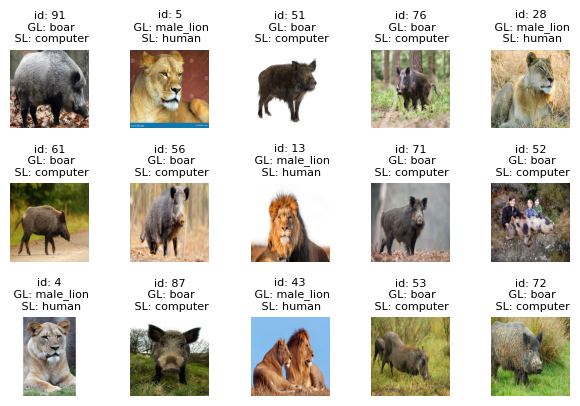

In [50]:
plot_label_issue_examples(label_issues_df, num_examples=15)